In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from datetime import date
import sqlite3
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from arch import arch_model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
database = sqlite3.connect("Dataset.db")
data = pd.read_sql_query("SELECT * FROM Data", database)
data = data.rename(columns={"('EURUSD Curncy', 'PX_LAST')": "EURUSD","('EURCHF Curncy', 'PX_LAST')": "EURCHF","('EURDKK Curncy', 'PX_LAST')":"EURDKK","('EURGBP Curncy', 'PX_LAST')": "EURGBP","('EURCAD Curncy', 'PX_LAST')": "EURCAD","('EURAUD Curncy', 'PX_LAST')": "EURAUD","('EURJPY Curncy', 'PX_LAST')": "EURJPY","('EURNOK Curncy', 'PX_LAST')": "EURNOK","('EURSEK Curncy', 'PX_LAST')": "EURSEK"})
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')
indexed_df = data.set_index('date')
ts_eurusd = indexed_df['EURUSD']
ts_eurgbp = indexed_df['EURGBP']

In [2]:
from pylab import rcParams 
import warnings
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 16,8

In [3]:
ts_eurusd

date
2000-01-03    1.0243
2000-01-04    1.0296
2000-01-05    1.0321
2000-01-06    1.0328
2000-01-07    1.0295
               ...  
2022-04-11    1.0884
2022-04-12    1.0828
2022-04-13    1.0888
2022-04-14    1.0828
2022-04-15    1.0819
Name: EURUSD, Length: 5815, dtype: float64

In [4]:
returns_series = np.log(ts_eurusd).diff().dropna()

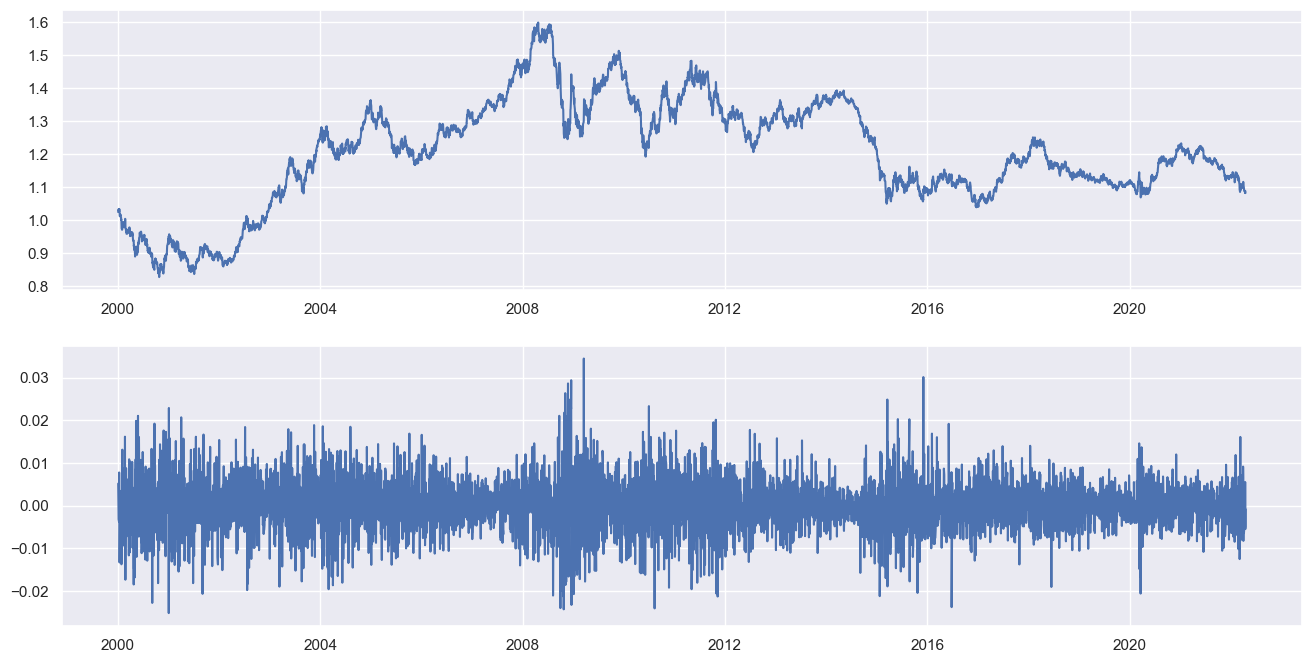

In [5]:
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(ts_eurusd.index.to_pydatetime(), ts_eurusd.values)
ax2.plot(returns_series)

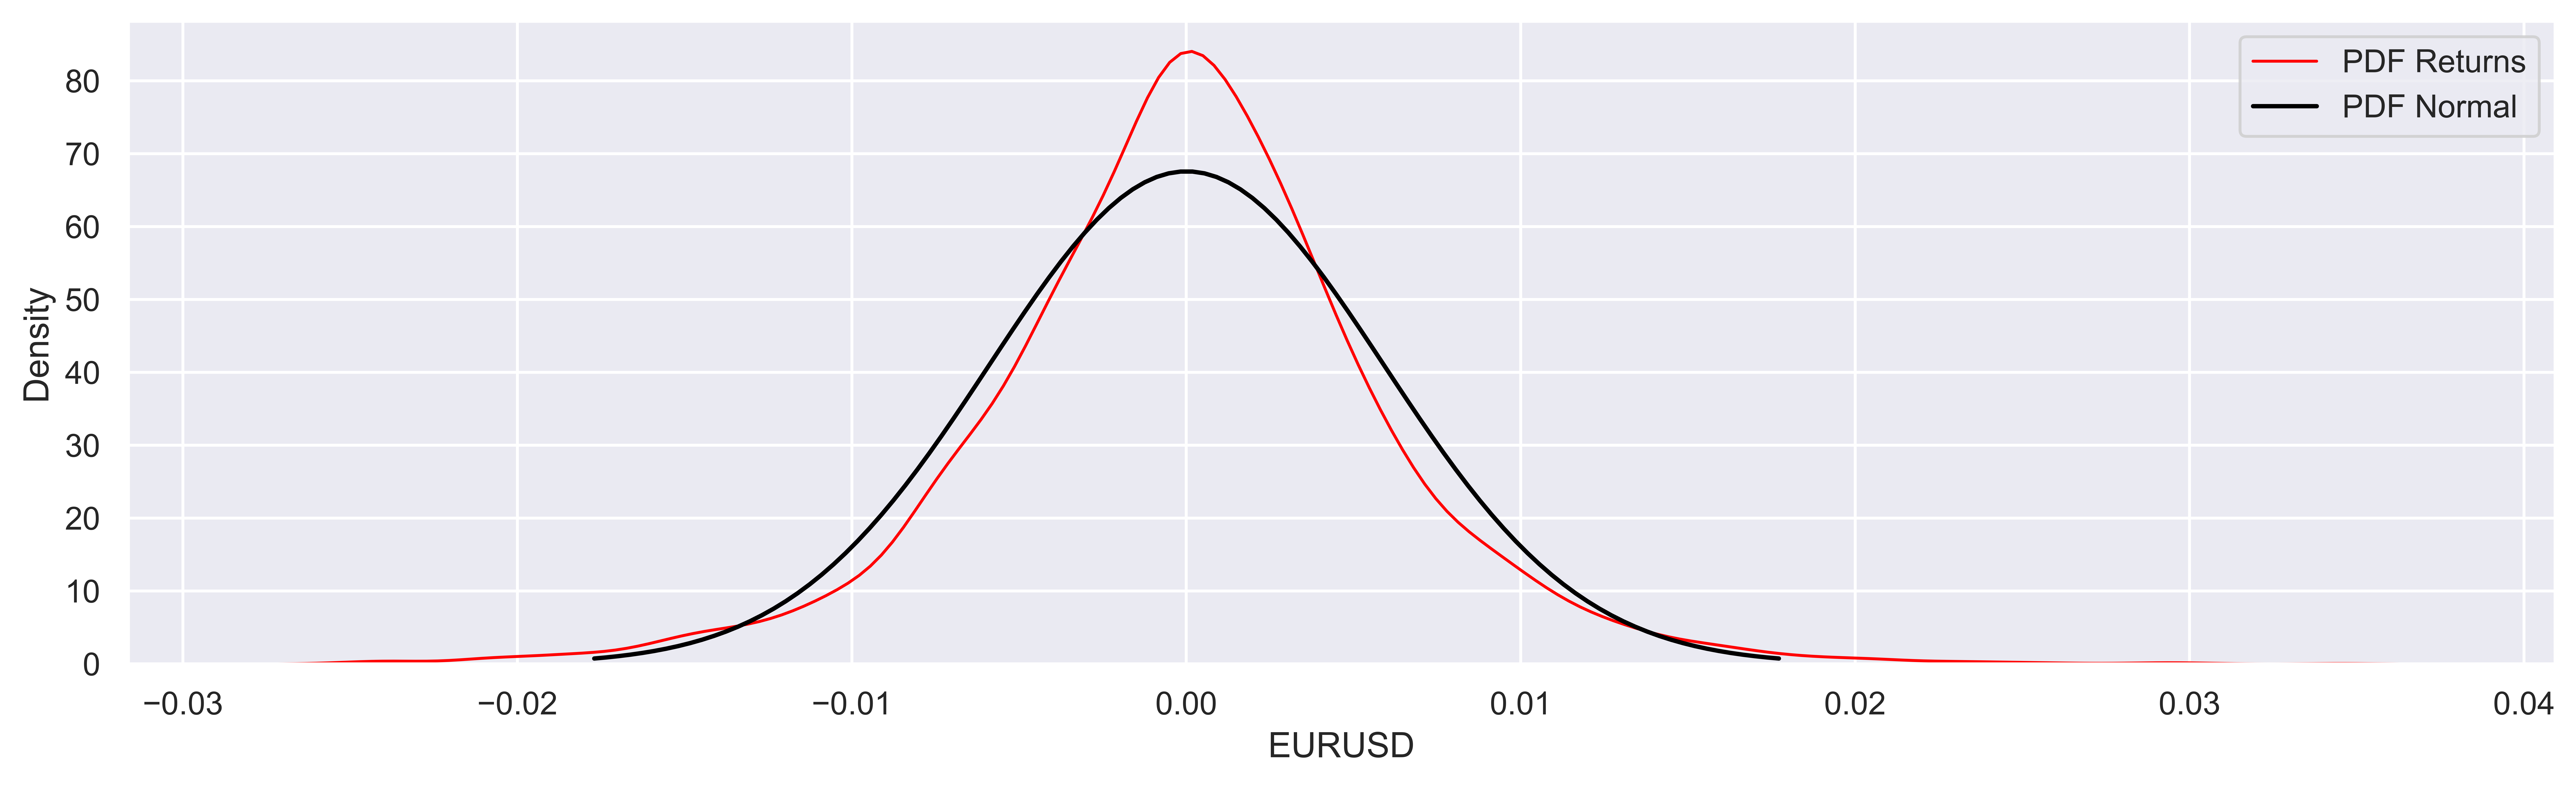

In [6]:
plt.figure(dpi = 1000, figsize=(15, 4))
sns.distplot(returns_series, hist=False, kde=True, bins=int(180/5), color = 'red',kde_kws={'linewidth': 1})
x = np.linspace(np.mean(returns_series) - 3*np.std(returns_series), np.mean(returns_series) +
3*np.std(returns_series), 100)
plt.plot(x, norm.pdf(x, np.mean(returns_series), np.std(returns_series)), color = 'black')
plt.legend(['PDF Returns', 'PDF Normal'])

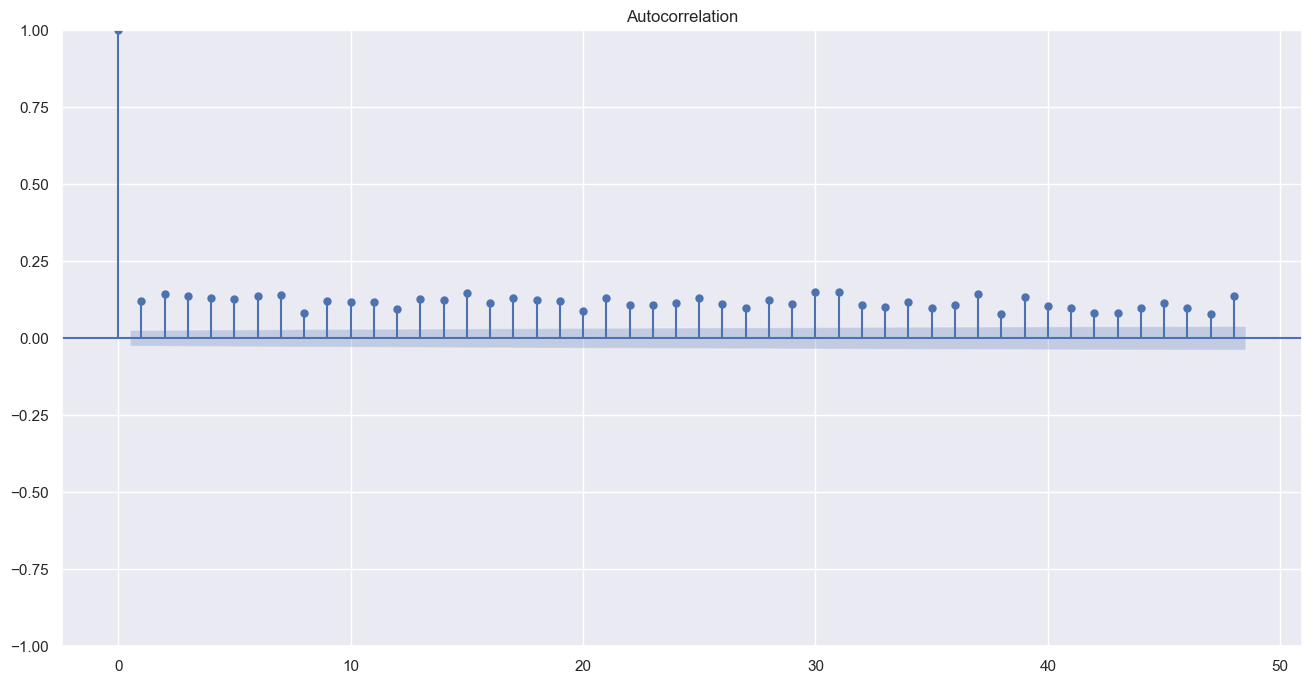

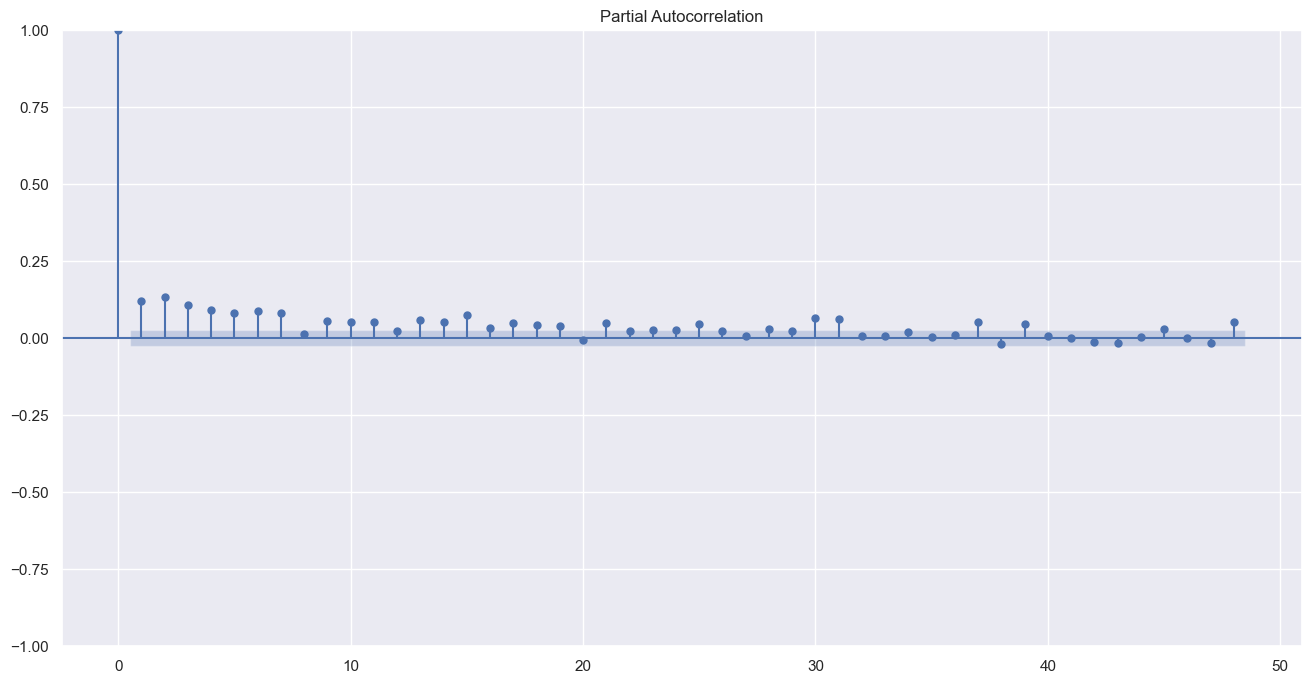

In [7]:
ax = sm.tsa.graphics.plot_acf(returns_series**2, lags=48)
ax = sm.tsa.graphics.plot_pacf(returns_series**2, lags=48)

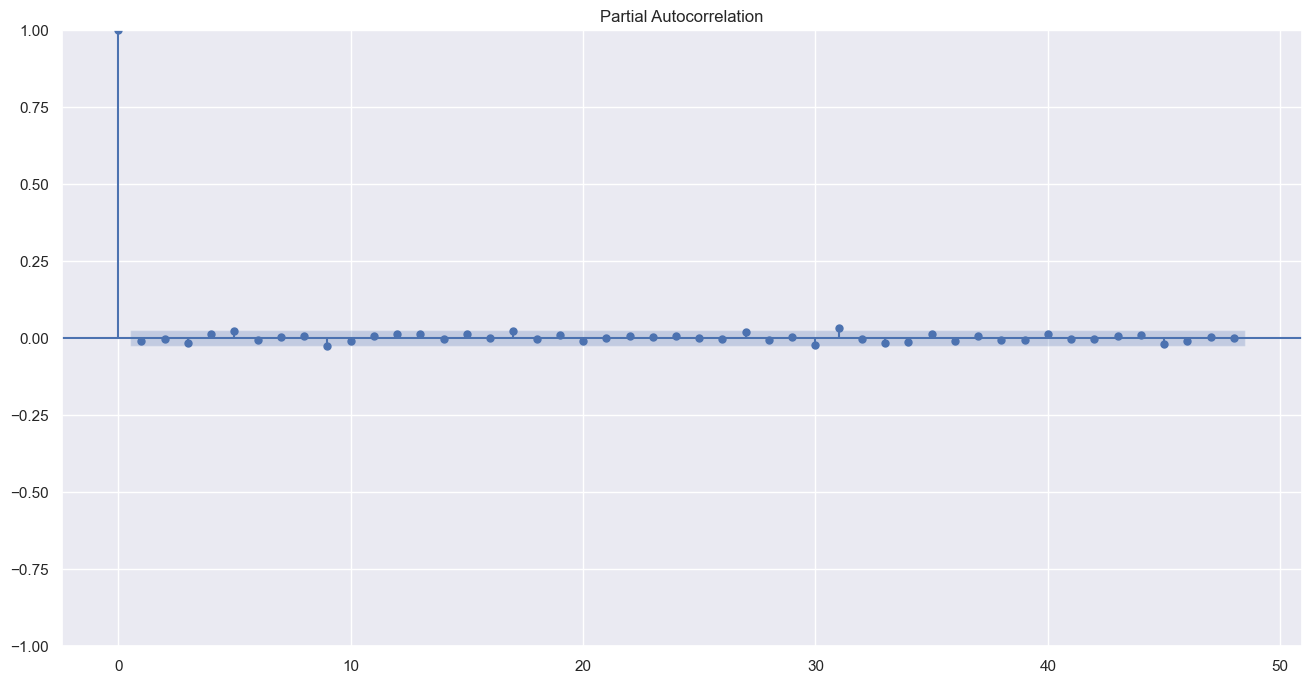

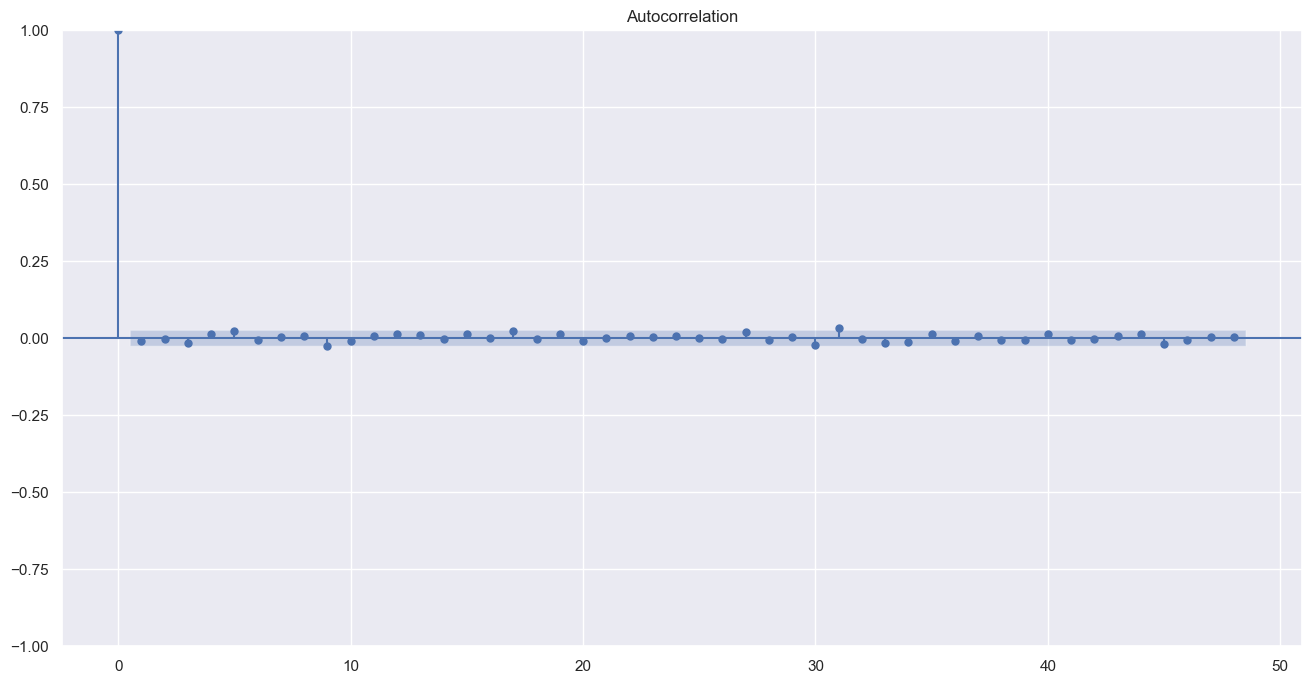

In [8]:
ax = sm.tsa.graphics.plot_pacf(returns_series, lags=48)
ax = sm.tsa.graphics.plot_acf(returns_series, lags=48)

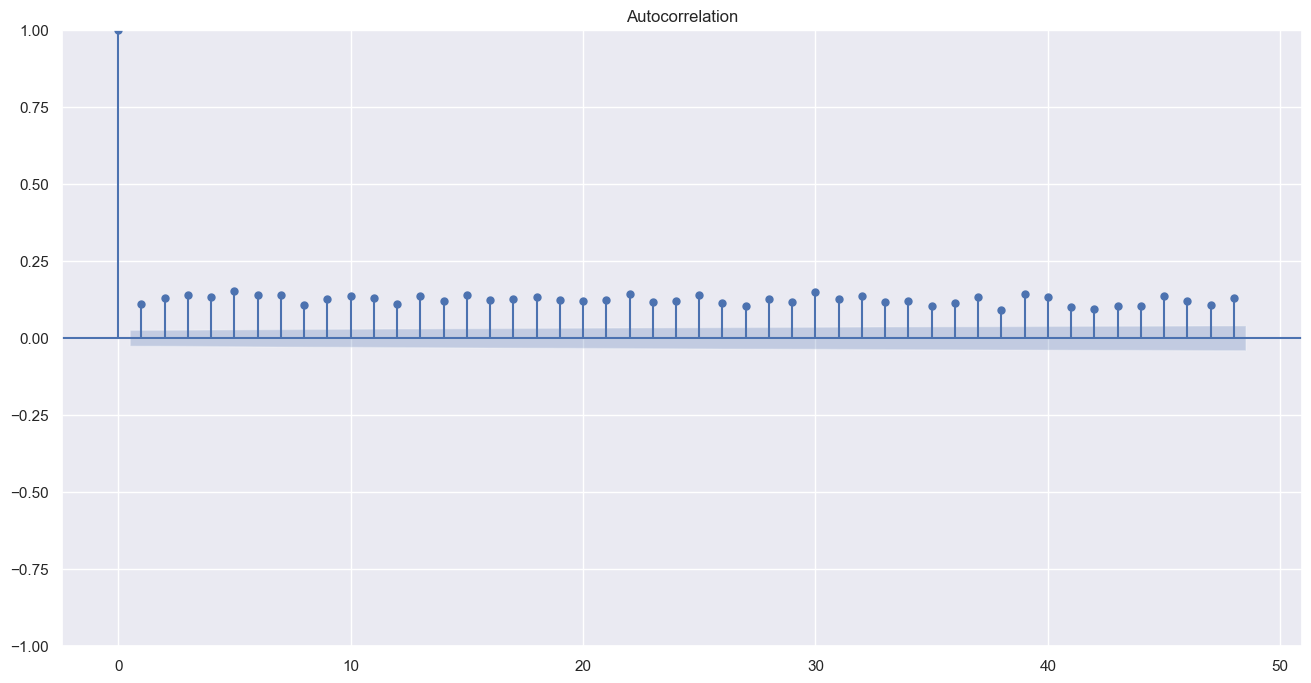

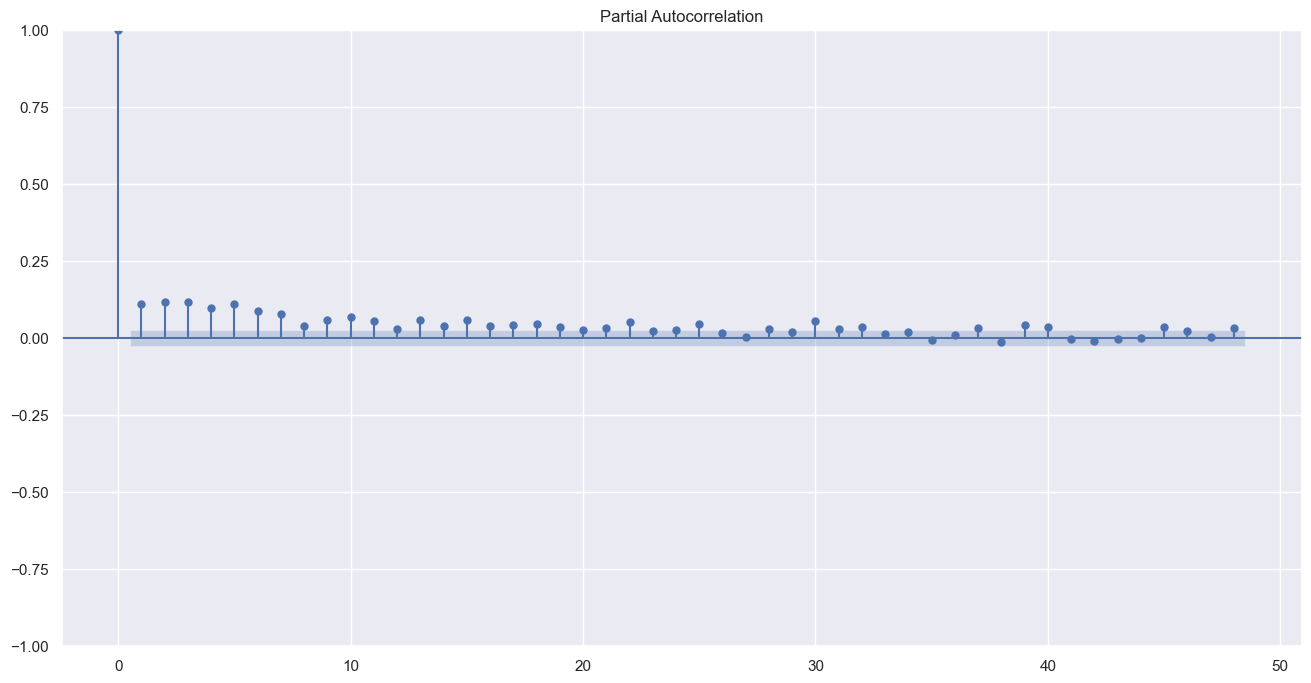

In [9]:
ax = sm.tsa.graphics.plot_acf(abs(returns_series), lags=48)
ax = sm.tsa.graphics.plot_pacf(abs(returns_series), lags=48)

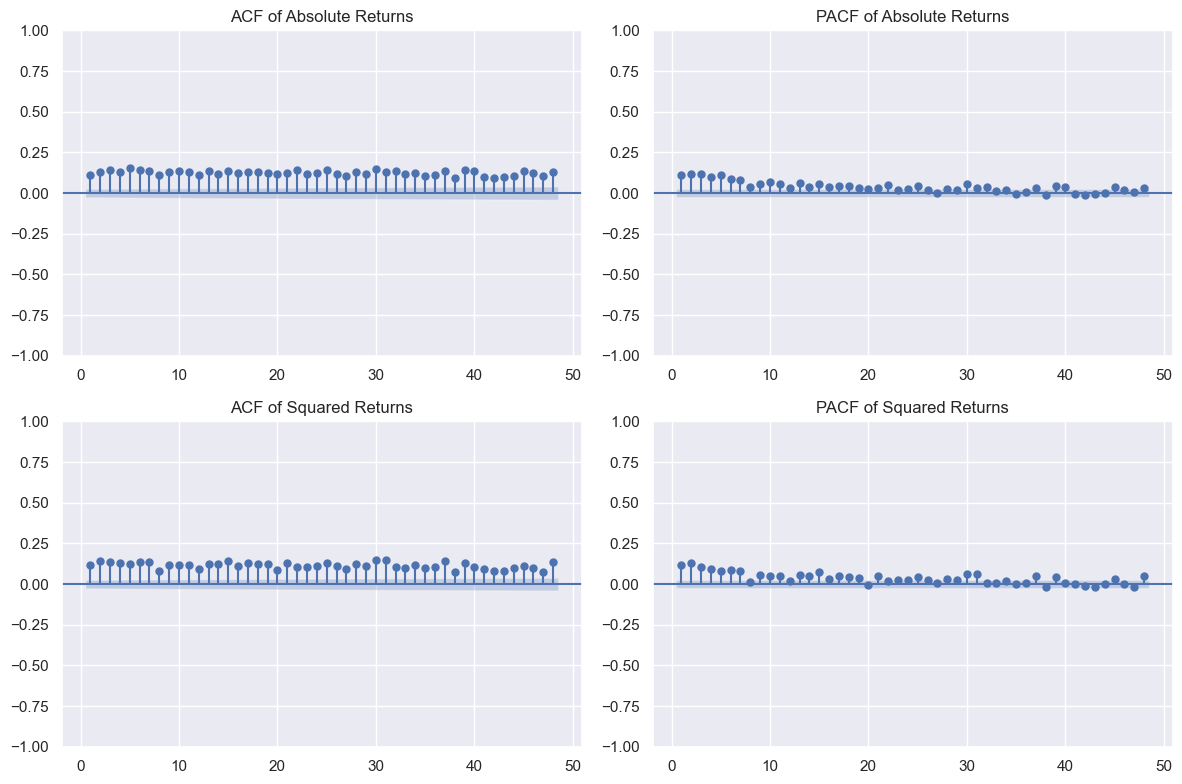

In [10]:
# Create figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Plot ACF and PACF
plot_acf(abs(returns_series), lags=48, zero=False, ax=ax1)
ax1.set_title('ACF of Absolute Returns')
plot_pacf(abs(returns_series), lags=48, zero=False, ax=ax2)
ax2.set_title('PACF of Absolute Returns')
plot_acf((returns_series**2), lags=48, zero=False, ax=ax3)
ax3.set_title('ACF of Squared Returns')
plot_pacf((returns_series**2), lags=48, zero=False, ax=ax4)
ax4.set_title('PACF of Squared Returns')

plt.tight_layout()
plt.show()

In [11]:
def check_stationarity(timeseries):
    
    #Determing rolling statistics
    rolling_mean = timeseries.rolling(window=25,center=False).mean() 
    rolling_std = timeseries.rolling(window=25,center=False).std()

    #Plot rolling statistics:
    original = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfresults = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfresults['Critical Value (%s)'%key] = value
    print (dfresults)

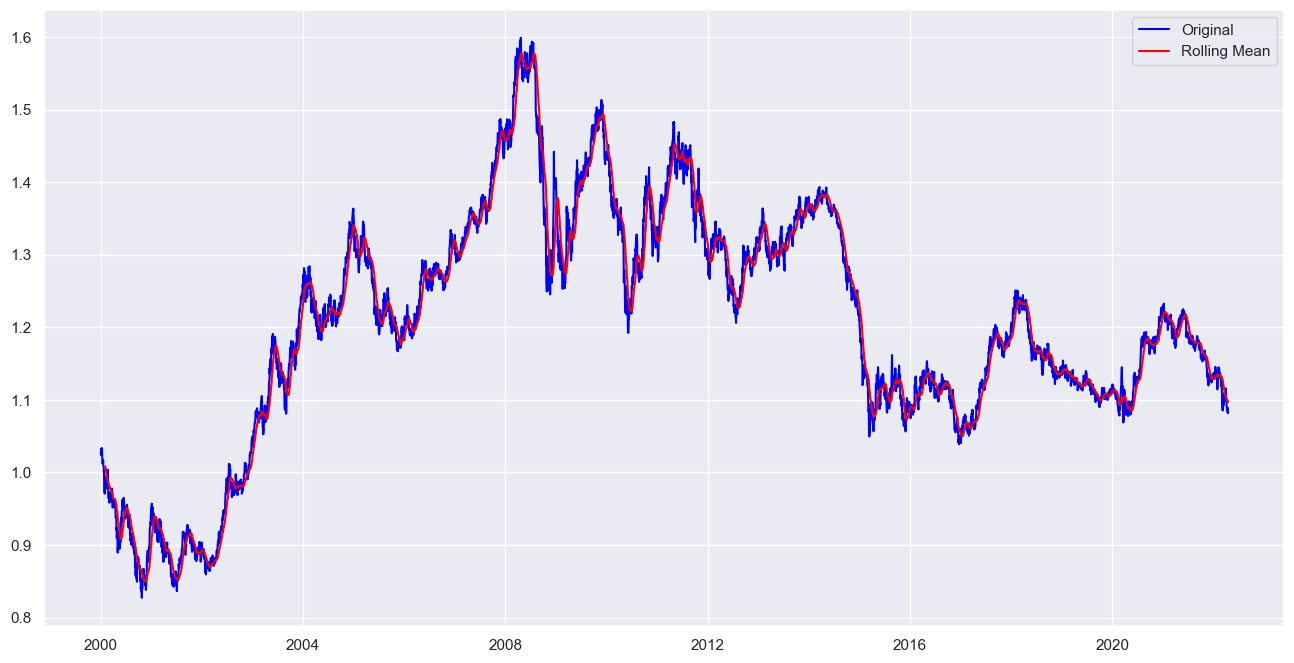

Results of Dickey-Fuller Test:
Test Statistic                   -1.813561
p-value                           0.373750
#Lags Used                        0.000000
Number of Observations Used    5814.000000
Critical Value (1%)              -3.431475
Critical Value (5%)              -2.862037
Critical Value (10%)             -2.567035
dtype: float64


In [12]:
check_stationarity((ts_eurusd))

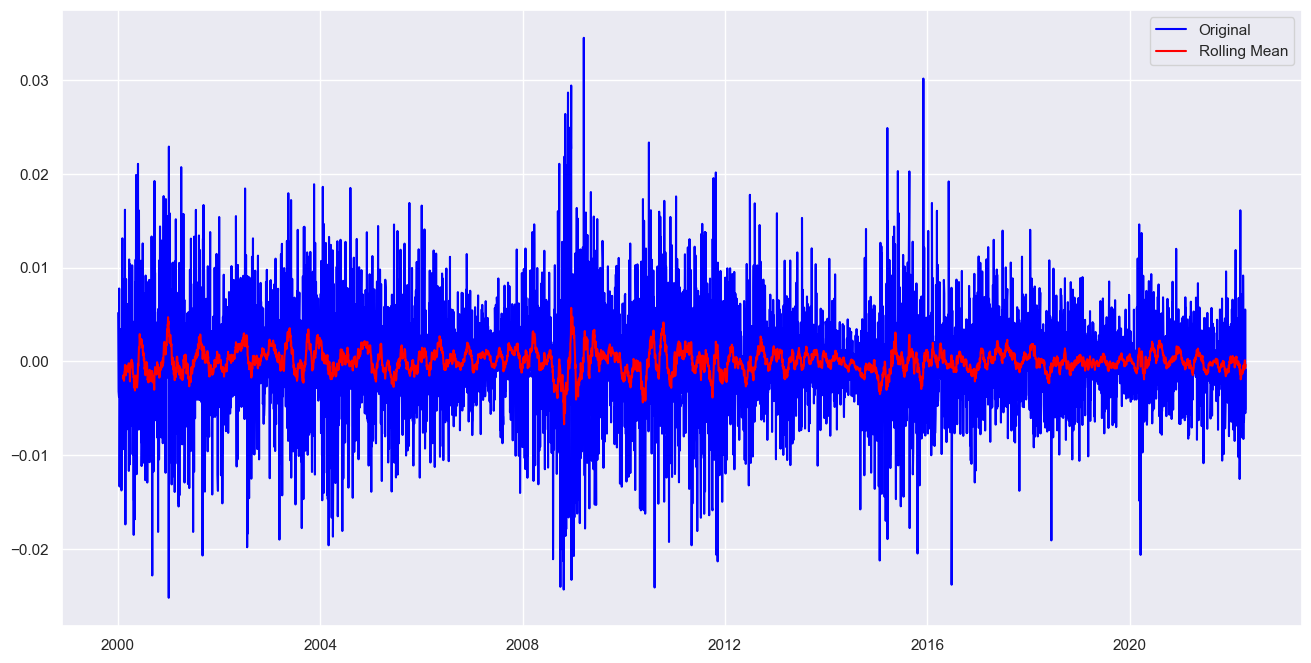

Results of Dickey-Fuller Test:
Test Statistic                  -76.988779
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    5813.000000
Critical Value (1%)              -3.431475
Critical Value (5%)              -2.862037
Critical Value (10%)             -2.567035
dtype: float64


In [13]:
check_stationarity(returns_series)